<a href="https://colab.research.google.com/github/electro10000/Astrology-Dataset/blob/main/DSRP_Solar_Flare_Research_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
### functions/libraries ###

import warnings
warnings.filterwarnings('ignore')

!pip install pandas --quiet
import pandas as pd

!pip install numpy --quiet
import numpy as np

!pip install matplotlib --quiet
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

!pip install ucimlrepo --quiet
from ucimlrepo import fetch_ucirepo

from scipy.stats import ttest_ind

import statsmodels.stats.multicomp as mc

!pip install scikit-learn --quiet
from sklearn import datasets, model_selection, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [16]:
### the actual dataset ###

# fetch dataset
solar_flare = fetch_ucirepo(id=89)

# data (as pandas dataframes)
X = solar_flare.data.features
y = solar_flare.data.targets

# metadata
#         print(solar_flare.metadata)

# variable information
#         print(solar_flare.variables)


### **Information about the Variables**
 1. Code for class (modified Zurich class)  (A,B,C,D,E,F,H)
 2. Code for largest spot size              (X,R,S,A,H,K)
 3. Code for spot distribution              (X,O,I,C)
 4. Activity                                (1 = reduced, 2 = unchanged)
 5. Evolution                               (1 = decay, 2 = no growth, 3 = growth)
 6. Previous 24 hour flare activity code    (1 = nothing as big as an M1, 2 = one M1, 3 = more activity than one M1)
 7. Historically-complex                    (1 = Yes, 2 = No)
 8. Did region become historically complex  on this pass across the sun's disk (1 = yes, 2 = no)
 9. Area                                    (1 = small, 2 = large)
 10. Area of the largest spot                (1 = <=5, 2 = >5)

From all these predictors three classes of flares are predicted, which are represented in the last three columns (all as numbers):

  11. C-class flares production by this region in the following 24 hours (common flares)
  12. M-class flares production by this region in the following 24 hours (moderate flares)
  13. X-class flares production by this region in the following 24 hours (severe flares)


In [17]:
X.head()

,modified Zurich class,largest spot size,spot distribution,activity,evolution,previous 24 hour flare activity,historically-complex,became complex on this pass,area,area of largest spot
0,C,S,O,1,2,1,1,2,1,2
1,D,S,O,1,3,1,1,2,1,2
2,C,S,O,1,3,1,1,2,1,1
3,D,S,O,1,3,1,1,2,1,2
4,D,A,O,1,3,1,1,2,1,2


In [18]:
X.describe()

,activity,evolution,previous 24 hour flare activity,historically-complex,became complex on this pass,area,area of largest spot
count,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000
mean,1.150468,2.421166,1.089993,1.395968,1.892009,1.025918,1.175666
std,0.357658,0.617129,0.403292,0.489234,0.310481,0.158948,0.380673
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000
50%,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000
75%,1.000000,3.000000,1.000000,2.000000,2.000000,1.000000,1.000000
max,2.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000


In [19]:
y.describe()

,common flares,moderate flares,severe flares
count,1389.000000,1389.000000,1389.000000
mean,0.261339,0.067675,0.009359
std,0.760201,0.353695,0.103534
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,8.000000,5.000000,2.000000


In [20]:
y['severe flares'].value_counts()

,count
severe flares,
0,1377
1,11
2,1


In [21]:
X['modified Zurich class'].value_counts()

,count
modified Zurich class,
H,396
D,327
C,287
B,212
E,116
F,51


In [22]:
X['largest spot size'].value_counts()

,count
largest spot size,
S,514
A,277
R,256
X,210
K,94
H,38


In [23]:
X['spot distribution'].value_counts()

,count
spot distribution,
O,627
X,396
I,312
C,54


In [24]:
# Encode the modified Zurich class column:
X_encoded = pd.get_dummies(X, columns=['modified Zurich class'], prefix='zurich_class')

X_encoded = pd.get_dummies(X_encoded, columns=['largest spot size'], prefix='largest_spot_size')

X_encoded = pd.get_dummies(X_encoded, columns=['spot distribution'], prefix='spot_distribution')

# new dataframe combining target variables with the others
df_flare_xencoded = pd.concat([X_encoded, y], axis=1)

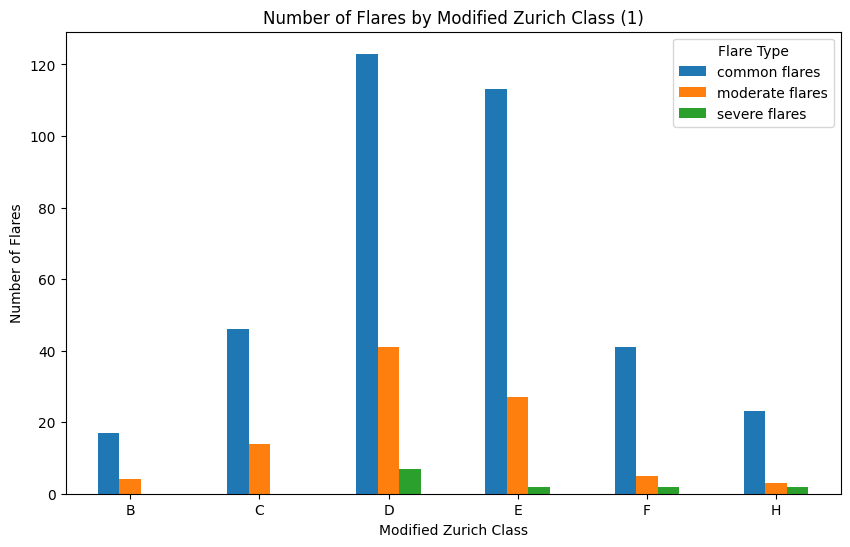

In [25]:
# grouping so it's easier to handle
zurich_classes = ['zurich_class_B', 'zurich_class_C', 'zurich_class_D', 'zurich_class_E', 'zurich_class_F', 'zurich_class_H']
df_flare_xencoded['zurich_class'] = df_flare_xencoded[zurich_classes].idxmax(axis=1).str.replace('zurich_class_', '')
flare_counts_by_zurich_class = df_flare_xencoded.groupby('zurich_class')[['common flares', 'moderate flares', 'severe flares']].sum()

# Plotting (I plotted this differently than what we learned to do since I had the x and y values in the same dataframe)
flare_counts_by_zurich_class.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Modified Zurich Class (1)')
plt.xlabel('Modified Zurich Class')
plt.ylabel('Number of Flares')
plt.xticks(rotation=0)
plt.legend(title='Flare Type')
plt.show()

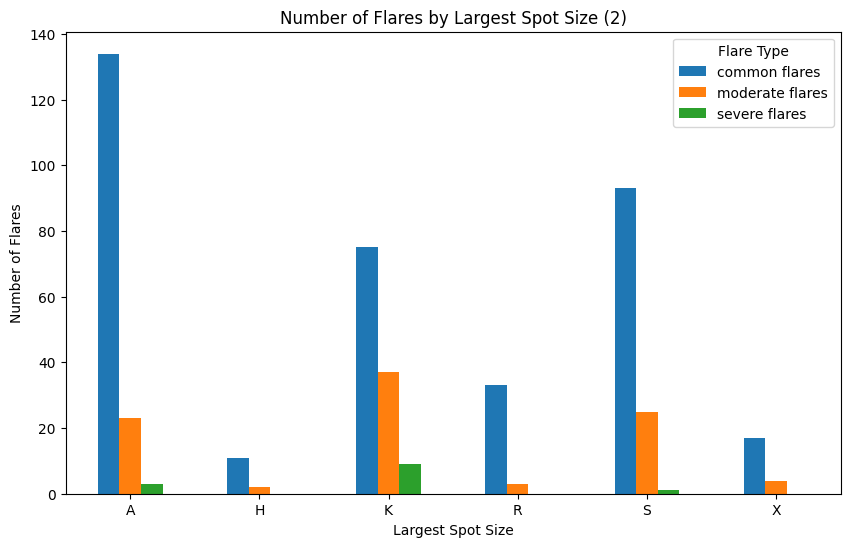

In [26]:
largest_spot_sizes = ['largest_spot_size_X', 'largest_spot_size_R', 'largest_spot_size_S', 'largest_spot_size_A', 'largest_spot_size_H', 'largest_spot_size_K']
df_flare_xencoded['largest_spot_size'] = df_flare_xencoded[largest_spot_sizes].idxmax(axis=1).str.replace('largest_spot_size_', '')
flare_counts_by_largest_spot_size = df_flare_xencoded.groupby('largest_spot_size')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_largest_spot_size.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Largest Spot Size (2)')
plt.xlabel('Largest Spot Size')
plt.ylabel('Number of Flares')
plt.xticks(rotation=0)
plt.legend(title='Flare Type')
plt.show()

In [27]:
a

NameError: name 'a' is not defined

In [ ]:
# plot for activity vs flares
flare_counts_by_activity = df_flare_xencoded.groupby('activity')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_activity.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Activity (5)')
plt.xlabel('Activity (1=Reduced, 2=Unchanged)')
plt.ylabel('Number of Flares')
plt.legend(title='Flare Type')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# plot for evolution vs flares
flare_counts_by_evolution = df_flare_xencoded.groupby('evolution')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_evolution.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Evolution (4)')
plt.xlabel('Evolution (1=Decay, 2=No Growth, 3=Growth)')
plt.ylabel('Number of Flares')
plt.legend(title='Flare Type')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# plot for previous 24 hour flare activity vs flares
flare_counts_by_prev_activity = df_flare_xencoded.groupby('previous 24 hour flare activity')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_prev_activity.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Previous 24 hr Flare Activity (8)')
plt.xlabel('Previous 24 hr Activity (1 = nothing as big as an M1, 2 = one M1, 3 = more activity than one M1)')
plt.ylabel('Number of Flares')
plt.legend(title='Flare Type')
plt.xticks(rotation=0)
plt.show()


# Historically-complex (1 = Yes, 2 = No)

In [ ]:
# plot for historical complexity vs flares
flare_counts_by_historical_complexity = df_flare_xencoded.groupby('historically-complex')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_historical_complexity.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Historical Complexity (7)')
plt.xlabel('Previous 24 hr Activity (1 =Historically Complex, 2=Not Historically Complex)')
plt.ylabel('Number of Flares')
plt.legend(title='Flare Type')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# plot for becoming complex on the most recent pass across the sun's disk vs flares
flare_counts_by_complex_this_pass = df_flare_xencoded.groupby('became complex on this pass')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_complex_this_pass.plot(kind='bar', figsize=(10, 6))
plt.title("Number of Flares by Whether or Not Sunspots Became Complex on the Most Recent Pass Around the Sun's Disk (10)")
plt.xlabel('Became Complex on This Pass (1 =yes, 2=no)')
plt.ylabel('Number of Flares')
plt.legend(title='Flare Type')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# plot for area vs flares
flare_counts_by_area = df_flare_xencoded.groupby('area')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_area.plot(kind='bar', figsize=(10, 6))
plt.title("Number of Flares by Area of Sunspot (9)")
plt.xlabel('Area (1 =small, 2=large)')
plt.ylabel('Number of Flares')
plt.legend(title='Flare Type')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# plot for area of largest spot vs flares
flare_counts_by_area_lgest_spot = df_flare_xencoded.groupby('area of largest spot')[['common flares', 'moderate flares', 'severe flares']].sum()

flare_counts_by_area_lgest_spot.plot(kind='bar', figsize=(10, 6))
plt.title("Number of Flares by Area of the Largest Spot (6)")
plt.xlabel('Area (1 = less than/equal to 5, 2 = more than 5) [units not specified]')
plt.ylabel('Number of Flares')
plt.legend(title='Flare Type')
plt.xticks(rotation=0)
plt.show()

### Research Question:
How does modified Zurich class and sunspot distribution affect the total amount of X class flares?

In [ ]:
x_flare_counts_by_zurich_class = df_flare_xencoded.groupby('zurich_class')['severe flares'].sum()

x_flare_counts_by_zurich_class.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Modified Zurich Class')
plt.xlabel('Modified Zurich Class')
plt.ylabel('Number of Flares')
plt.xticks(rotation=0)
plt.legend(title='Flare Type')
plt.show()

In [ ]:
x_flare_counts_by_spot_distribution = df_flare_xencoded.groupby('spot_distribution')['severe flares'].sum()

x_flare_counts_by_spot_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Flares by Spot Distribution')
plt.xlabel('Spot Distribution')
plt.ylabel('Number of Severe Flares')
plt.xticks(rotation=0)
plt.show()

In [ ]:
x_flare_counts_by_zurich_and_spot = df_flare_xencoded.groupby(['zurich_class', 'spot_distribution'])['severe flares'].sum().unstack()

# Plotting as a grouped bar chart
x_flare_counts_by_zurich_and_spot.plot(kind='bar', color=['red', 'orange', 'teal', 'green'], figsize=(12,6))
plt.title('Total Severe Flares by Modified Zurich Class and Spot Distribution')
plt.xlabel('Modified Zurich Class')
plt.ylabel('Number of Severe Flares')
plt.xticks(rotation=0)
plt.legend(title='Spot Distribution')
plt.show()

In [31]:
# 2-way Anova test

Xy = pd.concat([X, y], axis=1)

Xy['modified_Zurich_class'] = Xy['modified Zurich class'].astype('category')
Xy['spot_distribution'] = Xy['spot distribution'].astype('category')
Xy['severe_flares'] = Xy['severe flares']

anovamodel = ols('severe_flares ~ C(modified_Zurich_class) + C(spot_distribution)', data=Xy).fit()

anova_results = sm.stats.anova_lm(anovamodel, typ=2) # typ=2 is balanced, typ=3 unbalanced
anova_results

,sum_sq,df,F,PR(>F)
C(modified_Zurich_class),1.029439,5.0,20.702834,5.478487e-20
C(spot_distribution),0.996737,3.0,33.408600,7.611418e-21
Residual,13.733923,1381.0,NaN,NaN


In [32]:
features = ['zurich_class_B', 'zurich_class_C', 'zurich_class_D', 'zurich_class_E', 'zurich_class_F', 'zurich_class_H',
            'spot_distribution_X', 'spot_distribution_O', 'spot_distribution_I', 'spot_distribution_C']
Xrf = df_flare_xencoded[features]
yrf = df_flare_xencoded['severe flares']

X_train, X_test, y_train, y_test = train_test_split(Xrf, yrf, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

predrf = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, predrf)
precision = precision_score(y_test, predrf, average='weighted', zero_division=0)
recall = recall_score(y_test, predrf, average='weighted', zero_division=0)
f1 = f1_score(y_test, predrf, average='weighted', zero_division=0)


print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1-score: " + str(f1))

Accuracy: 0.988009592326139
Precision: 0.9761629545284636
Recall: 0.988009592326139
F1-score: 0.9820505477403362


In [ ]:
matrix = confusion_matrix(y_test, predrf, labels=[0, 1, 2])
# I put the labels while I was creating the confusion matrix to force it to be a 3x3
# It wouldn't predict for 2 severe flares because that only appears once in the whole dataset
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[0, 1, 2])

display.plot()
plt.title("Confusion matrix for the random forest model")
plt.show()